In [8]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

In [37]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [38]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [4]:
sample_edge = torch.tensor([[1, 1, 1],
                            [0, 0, 0],
                            [-1, -1, -1]])

<AxesSubplot:>

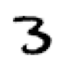

In [9]:
im = Image.open(path/'train'/'3'/'12.png')
show_image(im)

In [15]:
im = tensor(im)
im[:10,:10]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,  12,  99,  91, 142, 155, 246, 182],
        [  0,   0,   0, 138, 254, 254, 254, 254, 254, 254],
        [  0,   0,   0, 220, 254, 254, 254, 235, 189, 189],
        [  0,   0,   0,  35,  74,  35,  35,  25,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=torch.uint8)

In [23]:
pd.DataFrame(im).style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0,0,0,0,0,0,0,0,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0,0,0,0,0,0,0,0,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0,0,0,0,0,0,0,0,0


In [24]:
def apply_kernel3(im, row, col, kernel):
    return (im[row-1:row+2,col-1:col+2]*kernel).sum()

In [29]:
def first_conv(im, kernel):
    test_conv = tensor([[apply_kernel3(im, i, j, kernel) for j in range(1,27)] for i in range(1,27)])
    return test_conv

<AxesSubplot:>

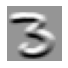

In [31]:
show_image(first_conv(im, sample_edge))

In [35]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [40]:
dls = DataBlock(
    (ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y=parent_label).dataloaders(path)

In [41]:
x, y = dls.one_batch()

In [42]:
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [76]:
sample_edge = sample_edge.unsqueeze(0).unsqueeze(0)

In [77]:
sample_edge = sample_edge.float()

In [81]:
batch_features = F.conv2d(to_cpu(x),sample_edge)

<AxesSubplot:>

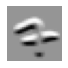

In [84]:
show_image(batch_features[0])

In [87]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [88]:
simple_cnn = nn.Sequential(
    conv(1,4),
    conv(4,8),
    conv(8,16),
    conv(16,32),
    conv(32,2,act=False),
    Flatten())

In [120]:
simple_cnn(x).shape

torch.Size([64, 2])

In [95]:
learn = Learner(dls, simple_cnn, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [96]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

SuggestedLRs(valley=0.010964781977236271)

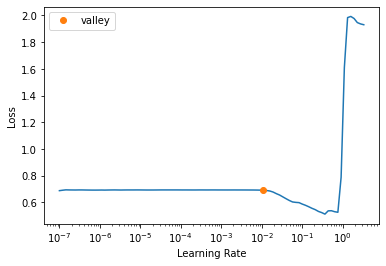

In [97]:
learn.lr_find()

In [98]:
learn.fit_one_cycle(3,0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.088996,0.043669,0.986261,00:05
1,0.021198,0.019554,0.993621,00:04
2,0.011176,0.014373,0.993621,00:04


In [104]:
learn.model[0][0], learn.model[0][0].weight, learn.model[0][0].bias

(Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Parameter containing:
 tensor([[[[ 0.1733, -0.3433,  0.0261],
           [-0.3171, -0.2345, -0.2754],
           [-0.2389, -0.2379,  0.0075]]],
 
 
         [[[-0.0266,  0.0156, -0.3424],
           [-0.0460, -0.2192, -0.2735],
           [ 0.0182,  0.4928,  0.1289]]],
 
 
         [[[-0.0053, -0.0257, -0.0504],
           [ 0.0861, -0.1159, -0.2073],
           [-0.2751,  0.0151,  0.0757]]],
 
 
         [[[ 0.2150, -0.3034, -0.1920],
           [ 0.1762,  0.4773, -0.1147],
           [ 0.2150,  0.4258,  0.1540]]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.3933,  0.0241, -0.2851,  0.0212], device='cuda:0',
        requires_grad=True))

In [109]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

In [111]:
path.ls(), (path/'training').ls()

((#2) [Path('training'),Path('testing')],
 (#10) [Path('training/8'),Path('training/3'),Path('training/9'),Path('training/2'),Path('training/4'),Path('training/1'),Path('training/0'),Path('training/5'),Path('training/7'),Path('training/6')])

In [123]:
def get_dls(bs=64):
    dls = DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training', 'testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=64)
    return dls

dls = get_dls()

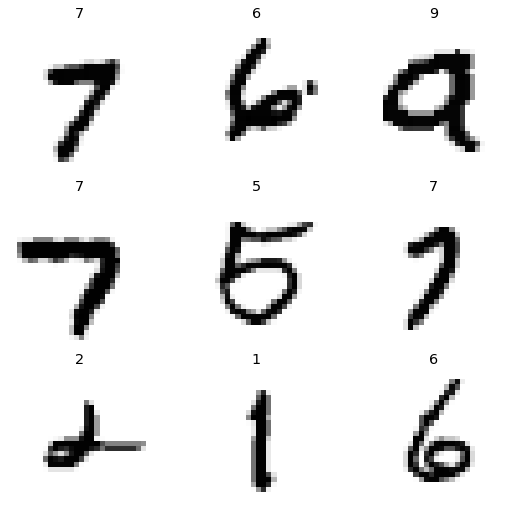

In [116]:
dls.show_batch()

In [127]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [128]:
def simple_cnn():
    return nn.Sequential(
        conv(1,8,ks=5),
        conv(8,16),
        conv(16,32),
        conv(32,64),
        conv(64,10,act=False),
        Flatten())

In [122]:
from fastai.callback.hook import *

In [130]:
dls = get_dls(512)

learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
learn.fit_one_cycle(1, 0.06)

epoch,train_loss,valid_loss,accuracy,time
0,0.173593,0.149614,0.953100,01:12


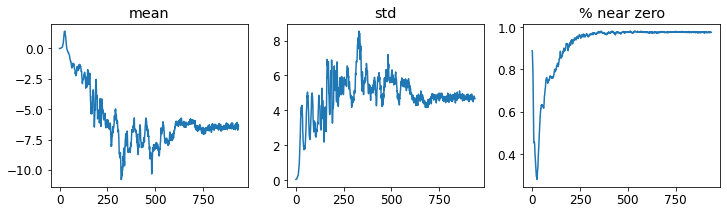

In [131]:
learn.activation_stats.plot_layer_stats(-2)

In [134]:
def conv(ni, nf, ks=3,act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [135]:
learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
learn.fit_one_cycle(1, 0.06)

epoch,train_loss,valid_loss,accuracy,time
0,0.064323,0.038872,0.988200,01:12


Need more sophistication: Batch Normalization and colordim

## Part 2

In [136]:
path = untar_data(URLs.IMAGENETTE_160)

(#4) [Path('/root/.fastai/data/imagenette2-160/train'),Path('/root/.fastai/data/imagenette2-160/val'),Path('/root/.fastai/data/imagenette2-160/.DS_Store'),Path('/root/.fastai/data/imagenette2-160/noisy_imagenette.csv')]

In [138]:
Path.BASE_PATH = path

In [139]:
path.ls()

(#4) [Path('train'),Path('val'),Path('.DS_Store'),Path('noisy_imagenette.csv')]

In [141]:
def create_dl(path, i_size, b_size):
    dls = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('train', 'val'),
        get_y=parent_label, 
        item_tfms=Resize(i_size),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=b_size),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)
    return dls

In [142]:
dls = create_dl(path, 160, 128)

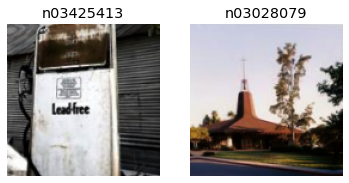

In [144]:
dls.show_batch(max_n=2)

In [145]:
def avg_pool(x):
    return x.mean((-1,-2))

In [150]:
def conv(ni, nf):
    return ConvLayer(ni, nf, stride=2)

def get_model():
    return nn.Sequential(
        conv(3, 4),
        conv(4, 8),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(64, dls.c))
        
# dls.c=len(dls.vocab)

In [151]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

In [152]:
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.163638,2.061005,0.253758,00:10
1,1.861766,1.741528,0.410191,00:10
2,1.625044,1.557409,0.477962,00:10
3,1.494750,1.427971,0.529427,00:10
4,1.437308,1.420987,0.534522,00:10


In [158]:
ConvLayer??

Init signature:
ConvLayer(
    ni,
    nf,
    ks=3,
    stride=1,
    padding=None,
    bias=None,
    ndim=2,
    norm_type=<NormType.Batch: 1>,
    bn_1st=True,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    transpose=False,
    init='auto',
    xtra=None,
    bias_std=0.01,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
)
Source:        
class ConvLayer(nn.Sequential):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    @delegates(nn.Conv2d)
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, ndim=2, norm_type=NormType.Batch, bn_1st=True,
                 act_cls=defaults.activation, transpose=False, init='auto', xtra=None, bias_std=0.01, **kwargs):
        if padding is None: padding = ((ks-1)//2 if not transpose else 0)
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in

## Resnet

In [167]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

In [168]:
def get_dls(bs=64):
    dls = DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training', 'testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=64)
    return dls

dls = get_dls(512)

In [169]:
x, y = dls.one_batch()

In [170]:
x.shape

torch.Size([64, 1, 28, 28])

In [175]:
def first_layer(*sizes):
    l = []
    for i in range(len(sizes)-1):
        if i==0:
            stride = 2
        else:
            stride = 1
        l += ConvLayer(sizes[i], sizes[i+1], ks=3, stride=stride)
    l += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
    return l       

In [172]:
def middle_layer(n_layers, n_in, n_out):
    l = []
    for i in range(n_layers):
        if i!=0:
            stride = 1
            n_in = n_out
        convs = nn.Sequential(
            ConvLayer(n_in, n_out, stride=stride),
            ConvLayer(n_out, n_out, act_cls=None, norm_type=NormType.BatchZero))
        idconv = noop if n_in==n_out else ConvLayer(ni,nf, 1, act_cls=None)
        pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        out = F.relu(convs + idconv(pool))
        l.append(out)

In [173]:
def last_layer(n_in, n_out):
    l = [nn.AdaptiveAvgPool2d(1), 
        Flatten(),
        nn.Linear(n_in, n_out)]
    return l

In [174]:
class ResNet(nn.Sequential):
    def __init__(self, ):
        first = first_layer()
        middle = middle_layer()
        last = last_layer()
        super().__init__(*first 
                         *middle
                         *last)